# Inverse design optimization of a metalens

> Note: native autograd support is an experimental feature in tidy3d 2.7. To see the original implementation of this notebook using jax and the adjoint plugin, refer to [this notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/AdjointPlugin7Metalens/).

In this notebook, we will use inverse design and the Tidy3D `autograd` feature to design a high numerical aperture (NA) metalens for optimal focusing to a point. This demo also introduces how to use automatic differentiation in `tidy3d` for objective functions that depend on the `FieldMonitor` outputs.

We will follow the basic set up from Mansouree et al. "Large-Scale Parametrized Metasurface Design Using Adjoint Optimization". The published paper can be found [here](https://pubs.acs.org/doi/abs/10.1021/acsphotonics.0c01058) and the arxiv preprint can be found [here](https://arxiv.org/abs/2101.06292).

<img src="img/adjoint_7.png" width=400 alt="Schematic of the metalens">


<!-- View this project in [Tidy3D Web App](https://tidy3d.simulation.cloud/workbench?taskId=d226dea4-9a65-4481-83d0-7f7d4cbfd388). -->

## Setup

We first perform basic imports of the packages needed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tidy3d as td
from tidy3d import web

import optax
from autograd import value_and_grad

The metalens design consists of a rectangular array of Si rectangular prisms sitting on an SiO2 substrate.

Here we define all of the basic parameters of the setup, including the wavelength, NA, geometrical dimensions, and material properties.


In [2]:
# 1 nanometer in units of microns (for conversion)
nm = 1e-3

# free space central wavelength
wavelength = 850 * nm
f0 = td.C_0 / wavelength
fwidth = f0 / 20

# desired numerical aperture
NA = 0.78

# shape parameters of metalens unit cell (um) (refer to image above and see paper for details)
H = 430 * nm
S = 320 * nm

# minimum and maximum radius of cylinder in unit cell
rmin = 50 * nm
rmax = S / 2 - 10 * nm  # to avoid touching cylinders

# space above and below metalens (in substrate and air, respectively)
buffer_z = wavelength / 2

# buffer region in x and y
buffer_xy = wavelength

# diameter of entire metalens (um)
diameter = 10

# Define material properties at 850 nm
n_Si = 3.84  # aSi
n_SiO2 = 1.45
air = td.Medium(permittivity=1.0)
SiO2 = td.Medium(permittivity=n_SiO2**2)
Si = td.Medium(permittivity=n_Si**2)

# define symmetry
symmetry = (-1, 1, 0)

# simulation run time
run_time = 100 / fwidth
min_steps_per_wvl = 10

Next, we will also define some derived parameters:

In [3]:
# Compute the domain size in x, y
length_xy = diameter + 2 * buffer_xy

# focal length given diameter and numerical aperture
focal_length = length_xy / 2 / NA * np.sqrt(1 - NA**2)

# total domain size in z: unit cells + buffer in z
length_z = H + 2 * buffer_z

# construct simulation size array
sim_size = (length_xy, length_xy, length_z)

## Create Metalens Geometry

Now we will define the structures in our simulation. We will first write a function to get the coordinates of the centers of the cylinders in the metalens.

In [4]:
def get_cylinder_centers(diameter, spacing, full_circle: bool = False):
    r_eff = diameter / 2 - spacing / 2  # max radius of centers
    coords = np.arange(0, r_eff, spacing)

    if full_circle:
        coords = np.concatenate([-coords[::-1], coords])

    x, y = np.meshgrid(coords, coords)
    points = np.vstack((x.flat, y.flat)).T

    # Create a boolean mask for points within the circle
    mask = x**2 + y**2 <= r_eff**2

    # Apply the mask to get the final points
    return points[mask.flat]

In [5]:
centers_quarter = get_cylinder_centers(diameter, S, full_circle=False)
centers_full = get_cylinder_centers(diameter, S, full_circle=True)
N = len(centers_full)

print(f"For a diameter of {diameter:.1f} µm, there are {N} cylinders.")
print(
    f"The metalens has an area of {np.pi * (diameter/2)**2:.1f} µm² and a focal length of {focal_length:.1f} µm."
)

For a diameter of 10.0 µm, there are 780 cylinders.
The metalens has an area of 78.5 µm² and a focal length of 4.7 µm.


Let's visualize the cell centers.

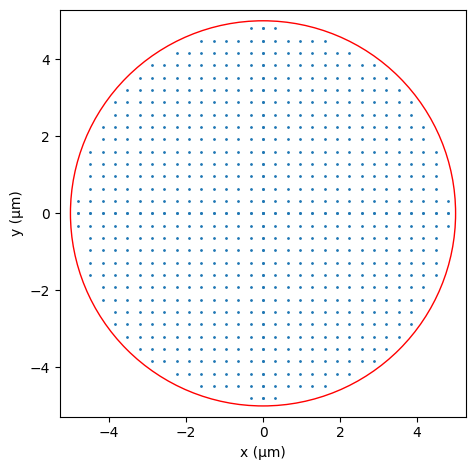

In [6]:
fig, ax = plt.subplots(1, 1, tight_layout=True)
ax.scatter(*get_cylinder_centers(diameter, S, full_circle=True).T, s=1)
circle = plt.Circle((0, 0), diameter / 2, color="r", fill=False)
ax.add_artist(circle)
ax.set_xlabel("x (µm)")
ax.set_ylabel("y (µm)")
ax.set_aspect("equal")
plt.show()

Now, we will start defining the structures in our simulation, starting with the substrate.

In [7]:
substrate = td.Structure(
    geometry=td.Box.from_bounds(
        rmin=(-td.inf, -td.inf, -1000),
        rmax=(+td.inf, +td.inf, -H / 2),
    ),
    medium=SiO2,
)

aperture = [
    td.Structure(
        geometry=td.Box.from_bounds(
            rmin=(-td.inf, -td.inf, -H / 2),
            rmax=(+td.inf, +td.inf, -H / 2 + 0.2),
        ),
        medium=td.PECMedium(),
    ),
    td.Structure(
        geometry=td.Cylinder(
            center=(0, 0, 0),
            radius=diameter / 2 + buffer_xy / 4,
            length=H,
        ),
        medium=air,
    ),
]

And we will write a function to make a `td.Structure` containing a `td.GeometryGroup` with a `td.Cylinder` for each unit cell.

> Note: while one could create a separate `td.Structure` for each `td.Cylinder`, using `td.GeometryGroup` leads to performance improvements, especially for the gradient processing.

In [8]:
def make_cylinders(params):
    """Make the metalens unit cell structures."""
    # scale the parameters to be between rmin and rmax
    radii = rmin + (rmax - rmin) / (1 + np.exp(-params))

    geometries = []
    for r, (x, y) in zip(radii, centers_quarter):
        geometry = td.Cylinder(center=(x, y, 0), radius=r, length=H)
        geometries.append(geometry)
    geo_group = td.GeometryGroup(geometries=geometries)
    medium = td.Medium(permittivity=n_Si**2)

    return td.Structure(medium=medium, geometry=geo_group)

## Define Source

Now we define the incident fields.  We simply use an x-polarized, normally incident plane wave with Gaussian time dependence centered at our central frequency.  For more details, see the [plane wave source documentation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PlaneWave.html#tidy3d-planewave) and the [gaussian source documentation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.GaussianPulse.html#tidy3d-gaussianpulse)

In [9]:
# time dependence of source
gaussian = td.GaussianPulse(freq0=f0, fwidth=fwidth, phase=0)

source = td.PlaneWave(
    source_time=gaussian,
    size=(td.inf, td.inf, 0),
    center=(0, 0, -H / 2 - buffer_z / 2),
    direction="+",
    pol_angle=0,
)

## Define Monitors

Now we define the monitor that measures field output from the FDTD simulation.  For simplicity, we use measure the fields at the central frequency at the focal spot.

This will be the monitor that we use in our objective function.

We additionally define the monitor used for the far field projection here, but note that it is not included in the simulation as we will perform the far field projection locally using the near field monitor.

In [10]:
monitor_near = td.FieldMonitor(
    center=(0, 0, H / 2 + buffer_z / 2),
    size=(td.inf, td.inf, 0),
    freqs=[f0],
    name="near_fields",
    colocate=False,
)

monitor_far = td.FieldProjectionAngleMonitor(
    center=monitor_near.center,
    size=monitor_near.size,
    freqs=monitor_near.freqs,
    name="far_fields",
    phi=[0],
    theta=[0],
    proj_distance=focal_length - buffer_z / 2,
    far_field_approx=False,
)

## Create Simulation

Now we can put everything together and define a `Simulation` object to be run.

> Note: we add symmetry of (-1, 1, 0) to speed up the simulation by approximately 4x taking into account the symmetry in our source and dielectric function.

In [11]:
def make_sim(params):
    structures = [substrate, *aperture]
    if params is not None:
        structures.append(make_cylinders(params))
    sim = td.Simulation(
        size=sim_size,
        structures=structures,
        sources=[source],
        monitors=[monitor_near],
        run_time=run_time,
        boundary_spec=td.BoundarySpec.all_sides(td.PML()),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=min_steps_per_wvl),
        symmetry=symmetry,
    )
    return sim

Let's define some initial parameters for the metalens.

In [12]:
params0 = np.zeros(len(centers_quarter))
sim = make_sim(params0)

## Visualize Geometry

Lets take a look and make sure everything is defined properly.
Note that we see only the upper right quadrant of the metalens, but this will be reflected across the other quadrants to create the full metalens due to the symmetry that we specified in the simulation.


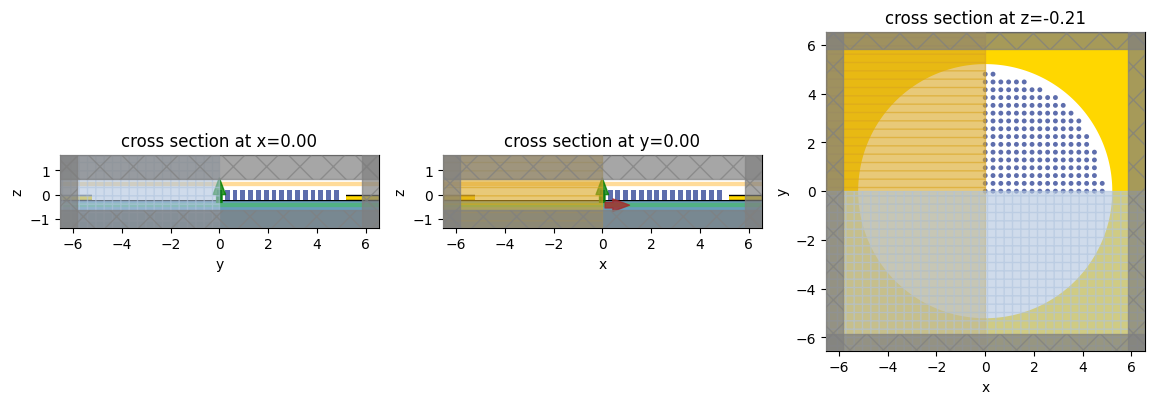

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 6))

sim.plot(x=0, ax=ax1)
sim.plot(y=0, ax=ax2)
sim.plot(z=-H / 2, ax=ax3)  # so we can see the aperture
plt.show()

## Objective Function

Now that our simulation is set up, we can define our objective function over the `td.SimulationData` results.

We first write a function to take a `td.SimulationData` object and return the projected far field power.

Next, we write a function to 

1. Set up our simulation given our design parameters.

2. Run the simulation through the adjoint `run` function.

3. Compute and return the intensity at the focal point.


In [14]:
def measure_focal_power(sim_data: td.SimulationData) -> float:
    """Measures far field power at focal point."""
    projector = td.FieldProjector.from_near_field_monitors(
        sim_data=sim_data,
        near_monitors=[monitor_near],
        normal_dirs=["+"],
        pts_per_wavelength=None,
    )
    projected_fields = projector.project_fields(monitor_far)
    return projected_fields.power.sum().item()


def J(params) -> float:
    """Objective function, returns power at focal point as a function of params."""
    sim = make_sim(params)
    sim_data = web.run(sim, task_name="metalens_invdes", verbose=False)
    return measure_focal_power(sim_data)

Next, we use `autograd` to get a function returning the objective value and its gradient, given some parameters.

In [15]:
dJ = value_and_grad(J)

And try it out.

In [16]:
val, grad = dJ(params0)
print(val)
print(grad)

Output()

0.00404081689146625
[ 1.90136493e-04  1.95598447e-04  1.77976040e-04  1.56162982e-04
  2.80057089e-05 -8.07073622e-05 -1.14898317e-04 -6.01545248e-05
  3.89761154e-05  5.62757934e-05  1.08436057e-05 -3.22483676e-05
 -1.77579938e-05  1.14671322e-06  7.17750854e-05  1.16407432e-05
  1.93632124e-04  1.99017607e-04  1.79738338e-04  1.44930223e-04
  1.67489183e-05 -9.12119566e-05 -1.18028462e-04 -5.28028508e-05
  4.68515322e-05  5.41715477e-05  6.63727941e-06 -3.20573517e-05
 -1.75447933e-05  4.69826712e-06  5.62988782e-05 -1.28219932e-05
  1.84680306e-04  2.00164342e-04  1.70158009e-04  1.05823914e-04
 -2.38217373e-05 -1.16906616e-04 -1.17535205e-04 -3.32885013e-05
  5.55502353e-05  5.59617677e-05 -2.01895304e-06 -3.89537439e-05
 -1.75902167e-05  2.52692065e-05  3.94623204e-05  1.61949405e-04
  1.65651052e-04  1.12959107e-04  4.02487717e-05 -8.33522752e-05
 -1.36663249e-04 -9.58957504e-05  6.18561792e-06  7.15704594e-05
  4.30996316e-05 -2.06460960e-05 -3.72189918e-05 -7.36427351e-06
  4.3

### Normalize Objective

To normalize our objective function value to something more understandable, we first run a simulation with no metalens to compute the focal point intensity in this case. Then, we construct a new objective function value that normalizes the raw intensity by this value, giving us an "intensity enhancement" factor. In this normalization, if our objective is given by "x", it means that the intensity at the focal point is "x" times stronger with our design than with no structures at all.

In [17]:
J_empty = J(None)


def J_normalized(params):
    return J(params) / J_empty


val_normalized = val / J_empty

dJ_normalized = value_and_grad(J_normalized)

print(val_normalized)

Output()

0.2271460098807569


## Optimization

With our objective function set up, we can now run the optimization.

As before, we will `optax`'s "adam" optimization with initial parameters of all zeros (corresponding to cylinders of radius `rmax/2`).

In [18]:
# hyperparameters
num_steps = 10
learning_rate = 1e-1

# initialize adam optimizer with starting parameters
params = np.copy(params0)
optimizer = optax.adam(learning_rate=learning_rate)
opt_state = optimizer.init(params)

# store history
J_history = [val_normalized]
params_history = [params0]

for i in range(num_steps):
    # compute gradient and current objective function value
    value, gradient = dJ_normalized(params)

    # outputs
    print(f"step = {i + 1}")
    print(f"\tJ = {value:.4e}")
    print(f"\tgrad_norm = {np.linalg.norm(gradient):.4e}")

    # compute and apply updates to the optimizer based on gradient (-1 sign to maximize obj_fn)
    updates, opt_state = optimizer.update(-gradient, opt_state, params)
    params[:] = optax.apply_updates(params, updates)

    # save history
    J_history.append(value)
    params_history.append(params)

Output()

step = 1
	J = 2.2715e-01
	grad_norm = 6.7242e-02


Output()

step = 2
	J = 1.6251e+00
	grad_norm = 1.7064e-01


Output()

step = 3
	J = 3.9424e+00
	grad_norm = 2.7089e-01


Output()

step = 4
	J = 6.2299e+00
	grad_norm = 3.2458e-01


Output()

step = 5
	J = 9.2661e+00
	grad_norm = 3.9225e-01


Output()

step = 6
	J = 1.2995e+01
	grad_norm = 4.9377e-01


Output()

step = 7
	J = 1.6182e+01
	grad_norm = 5.8691e-01


Output()

step = 8
	J = 1.6656e+01
	grad_norm = 5.8399e-01


Output()

step = 9
	J = 1.7556e+01
	grad_norm = 7.1872e-01


Output()

step = 10
	J = 1.9352e+01
	grad_norm = 6.9759e-01


In [19]:
params_after = params_history[-1]

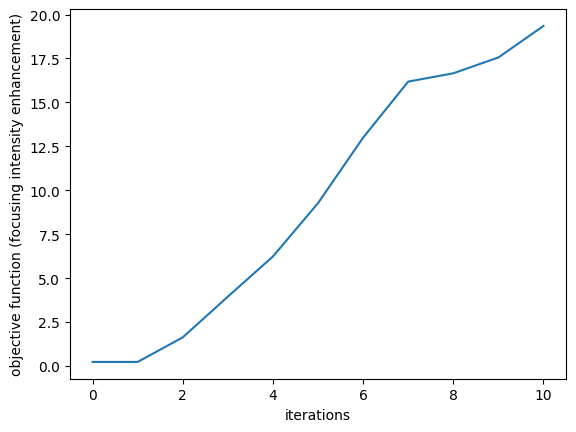

In [20]:
plt.plot(J_history)
plt.xlabel("iterations")
plt.ylabel("objective function (focusing intensity enhancement)")
plt.show()

In [21]:
sim_before = make_sim(params0)
sim_after = make_sim(params_after)

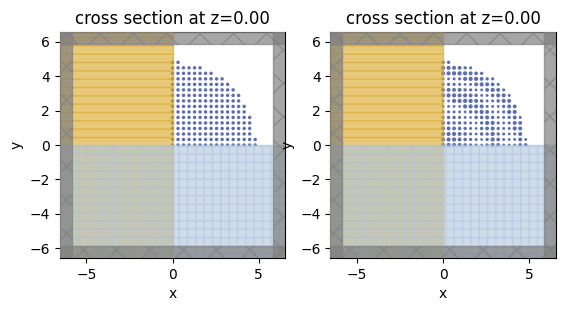

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2)

sim_before.plot(z=0, ax=ax1)
sim_after.plot(z=0, ax=ax2)

plt.show()

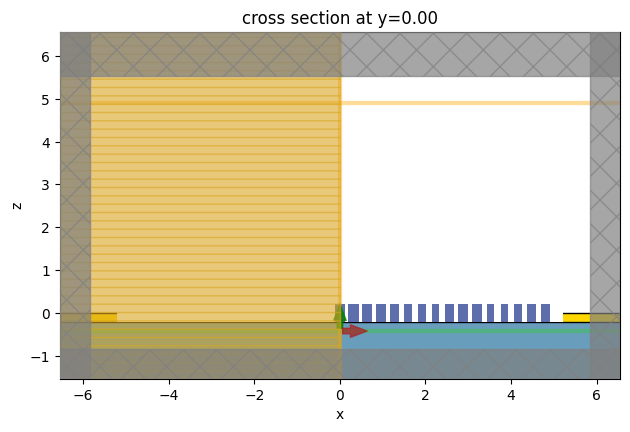

In [23]:
sim_after_mnt_xy = td.FieldMonitor(
    center=(*monitor_near.center[:2], H / 2 + focal_length),
    size=monitor_near.size,
    freqs=monitor_near.freqs,
    fields=("Ex", "Ey", "Ez"),
    name="focal_fields_xy",
)
sim_after_mnt_xz = td.FieldMonitor(
    size=(0, td.inf, td.inf),
    freqs=monitor_near.freqs,
    fields=("Ex", "Ey", "Ez"),
    name="focal_fields_yz",
)
sim_after_mnt = sim_after.updated_copy(
    center=(0, 0, focal_length / 2),
    size=(length_xy, length_xy, focal_length + 4 * buffer_z),
    monitors=[sim_after_mnt_xy, sim_after_mnt_xz],
)
sim_after_mnt.plot(y=0)
plt.show()

In [24]:
sim_data_after_mnt = web.run(sim_after_mnt, task_name="meta_near_field_after")

15:10:47 CET Created task 'meta_near_field_after' with task_id                  
             'fdve-8c339d99-9220-4a86-a3ec-c543e513a235' and task_type 'FDTD'.

             View task using web UI at                                          
             ]8;id=321165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=565317;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\taskId]8;;\]8;id=321165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\=]8;;\]8;id=806595;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\fdve]8;;\]8;id=321165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\-8c339d99-922]8;;\
             ]8;id=321165;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\0-4a86-a3ec-c543e513a235']8;;\.

Output()

15:10:51 CET status = queued

             To cancel the simulation, use 'web.abort(task_id)' or              
             'web.delete(task_id)' or abort/delete the task in the web UI.      
             Terminating the Python script will not stop the job running on the 
             cloud.

Output()

15:10:57 CET status = preprocess

15:10:59 CET Maximum FlexCredit cost: 0.506. Use 'web.real_cost(task_id)' to get
             the billed FlexCredit cost after a simulation run.

             starting up solver

             running solver

Output()

15:11:13 CET early shutoff detected at 12%, exiting.

15:11:14 CET status = postprocess

Output()

15:11:15 CET status = success

             View simulation result at                                          
             ]8;id=364943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=460830;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\taskId]8;;\]8;id=364943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\=]8;;\]8;id=473702;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\fdve]8;;\]8;id=364943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\-8c339d99-922]8;;\
             ]8;id=364943;https://tidy3d.simulation.cloud/workbench?taskId=fdve-8c339d99-9220-4a86-a3ec-c543e513a235\0-4a86-a3ec-c543e513a235']8;;\.

Output()

15:11:20 CET loading simulation from simulation_data.hdf5

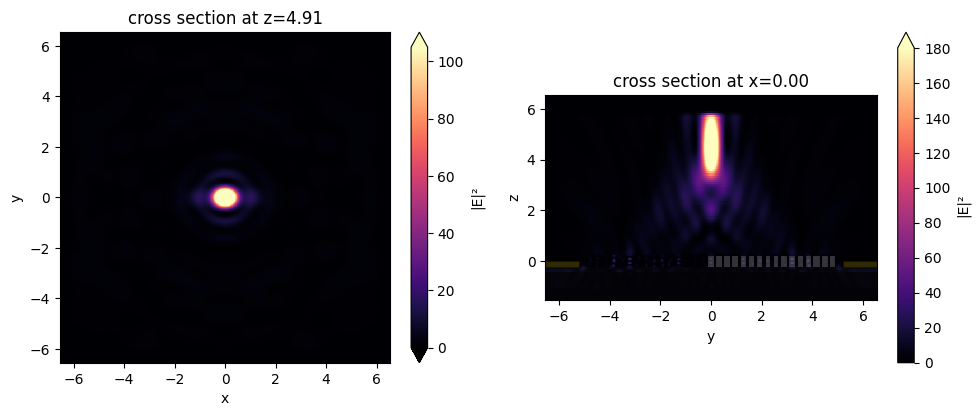

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(10, 4))
sim_data_after_mnt.plot_field("focal_fields_xy", field_name="E", val="abs^2", vmax=105, ax=ax1)
sim_data_after_mnt.plot_field("focal_fields_yz", field_name="E", val="abs^2", vmax=180, ax=ax2)
plt.show()

## Conclusions

We notice that our metalens does quite well at focusing at this high NA! For the purposes of demonstration, this is quite a small device, but the same the same principle can be applied to optimize a much larger metalens.

For more case studies using `autograd` support in `tidy3d`, see the

* [Gradient Checking Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd2GradientChecking/).

* [Inverse Design Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd3InverseDesign/).

* [Multi-Objective Gradient Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd4MultiObjective/).

* [Boundary Gradients Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd5BoundaryGradients/).

* [Grating Coupler Notebook](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd6GratingCoupler/).
